# Test Applications of Reward Brain Model
*Written by Luke Chang*

This notebook includes code used to test the Reward Model on novel applications such as Homeostatic state manipulation, Loss-aversion, and naturalistic data

# Load Modules and Functions

In [99]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from nltools.data import Brain_Data, Design_Matrix
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import (zscore, 
                           regress, 
                           find_spikes, 
                           one_sample_permutation, 
                           _calc_pvalue, 
                           downsample, 
                           correlation_permutation, 
                           summarize_bootstrap, 
                           threshold, 
                           fdr
                          )
from nltools.analysis import Roc
from nltools.file_reader import onsets_to_dm
from nltools.external import glover_hrf
from nltools.utils import get_anatomical
from nilearn.plotting import view_img, glass_brain, plot_stat_map, plot_anat, plot_glass_brain
from tqdm import tqdm
import pingouin as pg 
import re
from scipy.stats import pearsonr, spearmanr
from fnl_tools.stats import global_zscore
from fnl_tools.plotting import rec_to_time
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GroupKFold
# import plotly.express as px
from feat.plotting import plot_face
# from feat.utils import load_h5
from pymer4.models import Lmer, Lm, Lm2
from scipy.signal import convolve2d


def forced_choice_permutation_accuracy(data1, data2, model, tail=1, n_permutations=10000, metric='correlation'):
    '''Compute one-tailed p-values for forced choice accuracy using permutation test
    
    Args:
        data1: (Brain_Data) Brain_Data instance of Condition1(must be same subject order across conditions)
        data2: (Brain_Data) Brain_Data instance of Condition2 (must be same subject order across conditions)
        model: (Brain_Data) Brain_Data instance of model to test on each condition
        n_permutations: (int) Number of permutations to run, default 5,000
        
    Returns:
        dict: Dictionary with accuracy, one-tailed p-value, and null distribution
    '''
    
    if len(data1) != len(data1):
        raise ValueError('Conditions have a different number of subjects.')
        
    pexp = pd.DataFrame({'Condition1':data1.similarity(model, method=metric), 
                         'Condition2':data2.similarity(model, method=metric)})

    accuracy = np.mean(pexp['Condition1'] > pexp['Condition2'])

    null = []
    for iteration in range(n_permutations):
        null_iteration = []
        for i in range(len(pexp)):
            choice = np.random.choice([0,1])
            null_iteration.append(pexp.iloc[i, choice] > pexp.iloc[i, 1-choice])
        null.append(np.mean(null_iteration))

    return {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'null':null, 'pattern_similarity':pexp}


def plot_forced_choice_accuracy(data, line_color='lightgrey', line_width=2, line_style='-',
                                condition1_color='skyblue', condition2_color='navy',
                                point_size=8, labels=True, label_size=12, label_color='black',
                                ref_line=False, ref_line_style='--', ref_line_color='lightgrey',
                                text_gap=.005, vertical_gap=1, height_ratio=5, width_ratio=1.5):
    ''' Create a plot showing forced choice accuracy for each subject
    
    Args:
        line_color: (str) color of connecting line
        line_width: (int) width of connecting line
        line_style: (str) style of connecting line
        condition1_color: (str) color of marker for condition1
        condition2_color: (str) color of marker for condition2
        point_size: (int) size of marker
        labels: (bool) plot index as label
        label_size: (int) font size for label
        label_color: (str) font color for label
        ref_line: (bool) plot a reference line at x=0
        ref_line_style: (str) style for reference line
        ref_line_color: (str) color for reference line
        text_gap: (float) offset of text from point
        height_ratio: (float) scales figure height (i.e., distance between lines)
        width_ratio: (float) scales width of figure relative to height
        
    Returns:
        matplotlib object
    
    '''
    data.sort_values('Condition1', ascending=True, inplace=True)

    f,a = plt.subplots(figsize=(height_ratio*width_ratio, int(len(data)/height_ratio)))
    
    if ref_line:
        plt.axvline(0, linestyle=ref_line_style, color=ref_line_color)
    
    for i, idx in enumerate(data.iterrows()):
        row = idx[1]
        height = i/(len(data)/height_ratio)
#         height = ((i+)/((len(data)+1)/height_ratio))
        
        a.plot(row['Condition1'], height, color=condition1_color, marker='o', markersize=point_size)
        a.plot(row['Condition2'], height, color=condition2_color, marker='o', markersize=point_size)
        a.hlines(y=height, color=line_color, linestyle=line_style, linewidth=line_width,
                 xmax=max(row['Condition1'], row['Condition2']), 
                 xmin=min(row['Condition1'], row['Condition2']))
        
        if labels:
            a.annotate(int(row['Label']), xy=(min(row['Condition1'], row['Condition2'])-text_gap, height), 
                       horizontalalignment='right', verticalalignment='center',
                       size=label_size, color=label_color)
    
    a.get_yaxis().set_visible(False)
    a.set_xlim((min(data['Condition1'].min(), data['Condition2'].min() - text_gap - .05),
               max(data['Condition1'].max(), data['Condition2'].max() + text_gap + .05)))
    plt.tight_layout()
    
    
def plot_polar(data, n_top=3, overplot=False, palette='husl', 
               reorder=False, method='weighted', metric='correlation', labels=None,
               label_size=26, threshold=None, max_val=None,
               alpha_level=.8, legend=False, error_bars=None, line_width=4, line_alpha=.8):
    """ Make a polar plot
    data - Tabular data of shape features x classes with labels as index
    n_top - Number of features to select
    selection - Selection method to use `
                (top = M strongest for each class; std = N with greatest std across all)
    overplot - Overlap plots for each class?
    labels - Subset of features to use (overrides auto selection by n_top)
    palette - Color palette to use (can be label or list of colors from seaborn)
    reorder - If True, uses hierarchical clustering to reorder axis
    method - Method to use for clustering
    metric - Metric to use for clustering
    label_size - X axis label size
    threshold - Value to draw an optional line that denotes significance threshold
    max_val - Maximum value of y axis
    alpha_level - transparency value for lines
    legend - Show legend?
    error_bars - Option bootstrapped data to draw error bars
    line_width - width of lines
    line_alpha - alpha of lines
    """

    data = data.iloc[:n_top,:]
    n_panels = data.shape[1]
    
    if labels is not None:
        data = data.loc[labels,:]
    else:
        labels=data.index

    if error_bars is not None:
        error_bars = error_bars.loc[labels,:]

    if reorder is True:
        # Use hierarchical clustering to order
        from scipy.spatial.distance import pdist
        from scipy.cluster.hierarchy import linkage, leaves_list
        dists = pdist(data, metric=metric)
        pairs = linkage(dists, method=method)
        pairs[pairs < 0] = 0
        order = leaves_list(pairs)
        data = data.iloc[order,:]

        if error_bars is not None:
            error_bars = error_bars.iloc[order,:]

        labels = [labels[i] for i in order]


    theta = np.linspace(0.0, 2 * np.pi, len(labels), endpoint=False)
    
    ## Add first
    theta = np.concatenate([theta, [theta[0]]])
    if overplot:
        fig, ax = plt.subplots(1, 1, subplot_kw=dict(polar=True))
        fig.set_size_inches(10, 10)
    else:
        fig, axes = plt.subplots(n_panels, 1, sharex=False, sharey=False,
                             subplot_kw=dict(polar=True))
        fig.set_size_inches((6, 6 * n_panels))
        
    if isinstance(palette, str):
        from seaborn import color_palette
        colors = color_palette(palette, n_panels)
    else:
        colors = palette

    for i in range(n_panels):
        if overplot:
            alpha = alpha_level
        else:
            ax = axes[i]
            alpha = alpha_level

        if max_val is None:
            if error_bars is not None:
                max_val = data.values.max() + error_bars.values.max() + data.values.max() * .02
            else:
                max_val = data.values.max()
        
        ax.set_ylim(data.values.min(), max_val)
        
        d = data.iloc[:,i].values
        d = np.concatenate([d, [d[0]]])
        name = data.columns[i]

        if error_bars is not None:
            e = error_bars.iloc[:,i].values
            e = np.concatenate([e, [e[0]]])
        else:
            e = None

        if error_bars is not None:
            ax.errorbar(theta, d, yerr=e, capsize=0, color=colors[i], elinewidth = 3, linewidth=0)
        else:
            ax.plot(theta, d, alpha=line_alpha - 0.1, color=colors[i], linewidth=line_width, label=name)
            ax.fill(theta, d, ec='k', alpha=alpha, color=colors[i], linewidth=line_width)

        ax.set_xticks(theta)
        ax.set_rlabel_position(11.12)
        ax.set_xticklabels(np.concatenate([labels,[labels[0]]]), fontsize=label_size)
        [lab.set_fontsize(12) for lab in ax.get_yticklabels()]

    
    if threshold is not None:
        theta = np.linspace(0.0, 2 * np.pi, 999, endpoint=False)
        theta = np.concatenate([theta, [theta[0]]])
        d = np.array([threshold] * 1000)
        ax.plot(theta, d, alpha=1, color='black', linewidth=2, linestyle='--')

    if legend is True:
        ax.legend(bbox_to_anchor=(1.15, 1.1))

    plt.tight_layout()

    return labels, data


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    l.sort( key=alphanum_key )

    
def time_stamp_to_tr(time_stamp, tr=2.0):
    '''Convert Min:Sec string timestamp into TRs'''
    if ':' not in time_stamp:
        raise ValueError('Time Stamp must be in the format Min:Sec')

    if len(time_stamp.split(':')) != 2:
        raise ValueError('Time Stamp must be in the format Min:Sec')
    minutes, seconds = time_stamp.split(':')
    return int((int(minutes)*60 + int(seconds))/tr)


zscore = lambda x: (x - np.mean(x, axis=0)) / np.std(x, axis=0)
center = lambda x: (x - np.mean(x, axis=0))

data_dir = '/Storage/Projects/Reward_Model'
hcp_dir = '/Storage/Data/HCP'
beta_dir = '/Storage/Data/social_deprivation/'


# Load Models

In [20]:
analysis_name = 'demeaned_zscore1_smooth0'

mask = Brain_Data(os.path.join(data_dir, 'Masks', 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

neurosynth_reward = Brain_Data(os.path.join(data_dir, 'Masks', 'reward_association-test_z_FDR_0.01.nii.gz'))
reward_mask = neurosynth_reward.smooth(5).threshold(upper=3.5, binarize=True)

reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
reward_model_masked = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_masked_{analysis_name}_weightmap.nii.gz'))


# Test Social Deprivation Data
## Plot Reward Model performance on Social Deprivation Dataset

/tmp/ipykernel_783552/579823870.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  mit_deprivation_similarity_long = mit_deprivation_similarity.melt(id_vars=['Subject','Deprivation','Images'], value_name='Similarity')


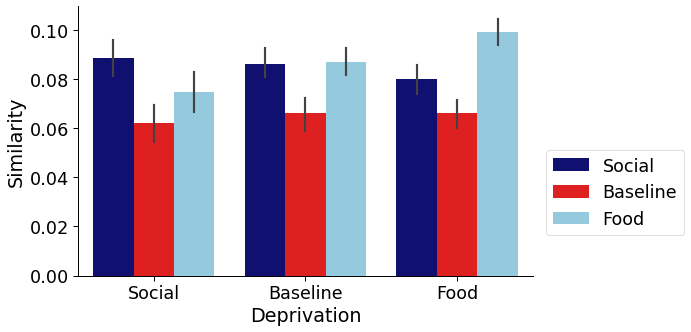

In [7]:
analysis_name = 'demeaned_zscore1_smooth0'

mit_deprivation_similarity = []
for session in ['s', 'b', 'f']:
    for condition in ['Social', 'Baseline', 'Food']:
        dat = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_{session}_Images_{condition}.hdf5'))
        tmp = pd.DataFrame({'Similarity':dat.similarity(reward_model, method='correlation')})
        tmp['Deprivation'] = session
        tmp['Images'] = condition
        tmp['Subject'] = [f'sub-{x:02}' for x in range(1,tmp.shape[0]+1)]
        mit_deprivation_similarity.append(tmp)
mit_deprivation_similarity = pd.concat(mit_deprivation_similarity)
mit_deprivation_similarity['Deprivation'].replace({'s':'Social','b':'Baseline','f':'Food'}, inplace=True)
mit_deprivation_similarity_long = mit_deprivation_similarity.melt(id_vars=['Subject','Deprivation','Images'], value_name='Similarity')
mit_deprivation_similarity_long.drop(columns='variable', inplace=True)
mit_deprivation_similarity_long.to_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.csv'), index=False)

with sns.plotting_context(context='paper', font_scale=2):
    colors = ['navy', 'red', 'skyblue']
    sns.catplot(data=mit_deprivation_similarity_long, x='Deprivation', y='Similarity', hue='Images', kind='bar', 
                ci=68, aspect=2, palette=sns.color_palette(colors), legend=False)
    plt.legend(bbox_to_anchor=(1.01, .5))
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.pdf'))              

## Plot Masked Reward Model on Social Deprivation Dataset

/tmp/ipykernel_783552/634331514.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  mit_deprivation_similarity_long = mit_deprivation_similarity.melt(id_vars=['Subject','Deprivation','Images'], value_name='Similarity')


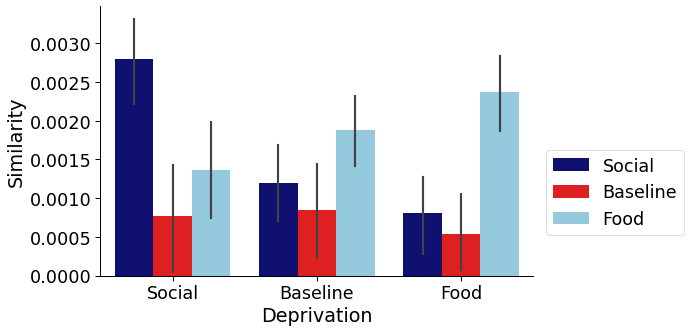

In [134]:
analysis_name = 'masked_demeaned_zscore1_smooth0'

mit_deprivation_similarity = []
for session in ['s', 'b', 'f']:
    for condition in ['Social', 'Baseline', 'Food']:
        dat = Brain_Data(os.path.join(data_dir, 'Data', 'social_isolation', f'MIT_Deprivation_Session_{session}_Images_{condition}.hdf5'))
        tmp = pd.DataFrame({'Similarity':dat.similarity(reward_model_masked, method='correlation')})
        tmp['Deprivation'] = session
        tmp['Images'] = condition
        tmp['Subject'] = [f'sub-{x:02}' for x in range(1,tmp.shape[0]+1)]
        mit_deprivation_similarity.append(tmp)
mit_deprivation_similarity = pd.concat(mit_deprivation_similarity)
mit_deprivation_similarity['Deprivation'].replace({'s':'Social','b':'Baseline','f':'Food'}, inplace=True)
mit_deprivation_similarity_long = mit_deprivation_similarity.melt(id_vars=['Subject','Deprivation','Images'], value_name='Similarity')
mit_deprivation_similarity_long.drop(columns='variable', inplace=True)
mit_deprivation_similarity_long.to_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.csv'), index=False)

with sns.plotting_context(context='paper', font_scale=2):
    colors = ['navy', 'red', 'skyblue']
    sns.catplot(data=mit_deprivation_similarity_long, x='Deprivation', y='Similarity', hue='Images', kind='bar', 
                ci=68, aspect=2, palette=sns.color_palette(colors), legend=False)
    plt.legend(bbox_to_anchor=(1.01, .5))
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures',f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures',f'MIT_Deprivation_Pattern_Similarity_{analysis_name}.pdf'))              

# Test Mixed Gambles Loss Aversion Dataset

## Compute similarity of reward model to each trial for each subject (only need to run once)

In [12]:
loss_aversion_path = '/Storage/Data/loss_aversion/derivatives/L1_Betas'

loss_aversion_file_list = glob.glob(os.path.join(loss_aversion_path, '*.nii.gz'))
sort_nicely(loss_aversion_file_list)

loss_aversion_images = Brain_Data(loss_aversion_file_list)

for analysis_name in tqdm(['demeaned_zscore1_smooth0', 'masked_demeaned_zscore1_smooth0']):
    reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
    loss_aversion_similarity = loss_aversion_images.similarity(reward_model, method='correlation')

    loss_aversion_metadata = pd.DataFrame([os.path.basename(x).split('_') for x in loss_aversion_file_list])
    loss_aversion_metadata.columns = ['Subject', 'Task', 'Run', 'Gain', 'Loss', 'Decision']

    loss_aversion_metadata['Gain'] = [int(x[4:]) for x in loss_aversion_metadata['Gain']]
    loss_aversion_metadata['Loss'] = [int(x[4:]) for x in loss_aversion_metadata['Loss']]
    loss_aversion_metadata['Decision'] = [int(x.split('.')[0][-1]) for x in loss_aversion_metadata['Decision']]
    loss_aversion_metadata['Similarity'] = loss_aversion_similarity

    loss_aversion_metadata.to_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'Loss_Aversion_Similarity_{analysis_name}.csv'), index=False)

100%|█████████████████████████████████████| 2/2 [00:06<00:00,  3.24s/it]


## Load Loss Aversion Similarity Data

In [57]:
analysis_name = 'demeaned_zscore1_smooth0'
# analysis_name = 'masked_demeaned_zscore1_smooth0'

loss_aversion_metadata = pd.read_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'Loss_Aversion_Similarity_{analysis_name}.csv'))

loss_aversion_metadata['Similarity_center'] = loss_aversion_metadata['Similarity'].groupby(loss_aversion_metadata['Subject']).transform(center)
loss_aversion_metadata['Similarity_z'] = loss_aversion_metadata['Similarity'].groupby(loss_aversion_metadata['Subject']).transform(zscore)
loss_aversion_metadata['Gain_z'] = loss_aversion_metadata['Gain'].groupby(loss_aversion_metadata['Subject']).transform(zscore)
loss_aversion_metadata['Loss_z'] = loss_aversion_metadata['Loss'].groupby(loss_aversion_metadata['Subject']).transform(zscore)
loss_aversion_metadata['Decision_4'] = loss_aversion_metadata['Decision']
loss_aversion_metadata['Decision'] = loss_aversion_metadata['Decision'].replace({1:1, 2:1, 3:0, 4:0,0:np.nan})
loss_aversion_metadata['Decision_4'] = loss_aversion_metadata['Decision_4'].replace({0:np.nan, 4:1, 3:2, 2:3, 1:4})



## Look for evidence of interaction in gain/loss pattern similarity data

/tmp/ipykernel_783552/2876208987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_aversion_metadata['Gain_Quantile'].loc[loss_aversion_metadata['Gain'] >=loss_aversion_metadata['Gain'].quantile(i/quantile)] = i + 1
/tmp/ipykernel_783552/2876208987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_aversion_metadata['Loss_Quantile'].loc[loss_aversion_metadata['Loss'] >=loss_aversion_metadata['Loss'].quantile(i/quantile)] = quantile-i


<AxesSubplot:xlabel='Loss_Quantile', ylabel='Similarity'>

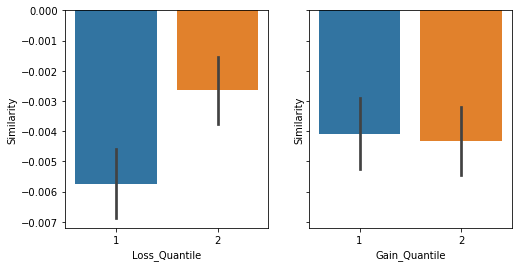

In [58]:
quantile=2
loss_aversion_metadata['Gain_Quantile'] = 0
loss_aversion_metadata['Loss_Quantile'] = 0
for i in range(quantile):
    loss_aversion_metadata['Gain_Quantile'].loc[loss_aversion_metadata['Gain'] >=loss_aversion_metadata['Gain'].quantile(i/quantile)] = i + 1
    loss_aversion_metadata['Loss_Quantile'].loc[loss_aversion_metadata['Loss'] >=loss_aversion_metadata['Loss'].quantile(i/quantile)] = quantile-i

f,a = plt.subplots(ncols=2, figsize=(8,4), sharey=True)
sns.barplot(data=loss_aversion_metadata, x='Gain_Quantile', y='Similarity', ax=a[1])

sns.barplot(data=loss_aversion_metadata, x='Loss_Quantile', y='Similarity', ax=a[0])


## Test Behavioral Data Gains/Loss

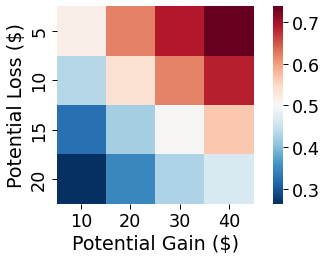

In [59]:
quantile=4
gain_loss = np.zeros((quantile, quantile))
for i in range(quantile):
    for j in range(quantile):    
        gain_loss[i,j] = loss_aversion_metadata.loc[(loss_aversion_metadata['Gain'] >=loss_aversion_metadata['Gain'].quantile(j/quantile)) & (loss_aversion_metadata['Loss'] >=loss_aversion_metadata['Loss'].quantile(i/quantile))]['Decision'].mean()
gain_loss = pd.DataFrame(gain_loss, columns=[x for x in range(10,50, int(40/quantile))], index=[x for x in range(5,25, int(20/quantile))])

with sns.plotting_context(context='paper', font_scale=2):
    sns.heatmap(gain_loss, cmap='RdBu_r', square=True)
    plt.xlabel('Potential Gain ($)')
    plt.ylabel('Potential Loss ($)')
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavior_Loss_Aversion_Quantile{quantile}_{analysis_name}_heatmap.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavior_Loss_Aversion_Quantile{quantile}_{analysis_name}_heatmap.pdf'))


## Test Neural Data Gains/Loss

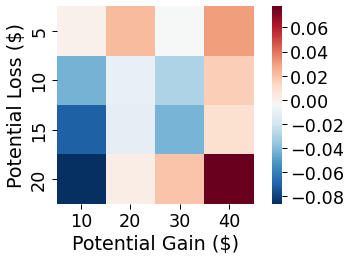

In [60]:
quantile=4
gain_loss = np.zeros((quantile, quantile))
for i in range(quantile):
    for j in range(quantile):    
        gain_loss[i,j] = loss_aversion_metadata.loc[(loss_aversion_metadata['Gain'] >=loss_aversion_metadata['Gain'].quantile(j/quantile)) & (loss_aversion_metadata['Loss'] >=loss_aversion_metadata['Loss'].quantile(i/quantile))]['Similarity_z'].mean()
gain_loss = pd.DataFrame(gain_loss, columns=[x for x in range(10,50, int(40/quantile))], index=[x for x in range(5,25, int(20/quantile))])

with sns.plotting_context(context='paper', font_scale=2):
    sns.heatmap(gain_loss, cmap='RdBu_r', square=True)
    plt.xlabel('Potential Gain ($)')
    plt.ylabel('Potential Loss ($)')
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Neural_Loss_Aversion_Quantile{quantile}_{analysis_name}_heatmap.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Neural_Loss_Aversion_Quantile{quantile}_{analysis_name}_heatmap.pdf'))


## Prediction Decision from Predicted Reward

In [61]:
model_decision = Lmer("Decision ~ Similarity + (Similarity|Subject)", data=loss_aversion_metadata.dropna(), family='binomial')
model_decision.fit()


boundary (singular) fit: see help('isSingular') 

Formula: Decision~Similarity+(Similarity|Subject)

Family: binomial	 Inference: parametric

Number of observations: 2617	 Groups: {'Subject': 16.0}

Log-likelihood: -1545.568 	 AIC: 3101.135

Random effects:

                Name    Var    Std
Subject  (Intercept)  1.077  1.038
Subject   Similarity  2.018  1.420

                 IV1         IV2  Corr
Subject  (Intercept)  Similarity  -1.0

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.130,-0.387,0.646,0.263,1.139,0.679,1.908,0.532,0.405,0.656,0.493,0.622,
Similarity,6.874,2.808,10.940,2.074,966.750,16.580,56370.567,0.999,0.943,1.000,3.314,0.001,***


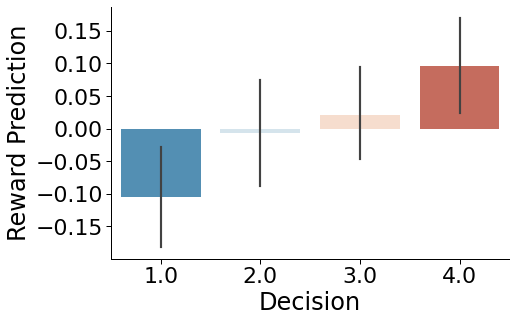

In [62]:
with sns.plotting_context(context='paper', font_scale=2.5):
    sns.catplot(data=loss_aversion_metadata, x='Decision_4', y='Similarity_z', kind='bar', 
                palette=sns.color_palette(palette='RdBu_r', n_colors=4), aspect=1.5, 
#                 order=['Strongly Accept','Weakly Accept', 'Weakly Reject', 'Strongly Reject']
               )
    plt.ylabel('Reward Prediction')
    plt.xlabel('Decision')
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavioral_Prediction_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavioral_Prediction_{analysis_name}.pdf'))


## Compute Accuracy for Whole Brain Model

In [35]:

n_permutations = 5000
tail=2
sub_dat = {}
for sub in loss_aversion_metadata['Subject'].unique():
    sub_dat[sub] = {'Accept':loss_aversion_metadata.query('Subject==@sub&Decision==1')['Similarity'].mean(),
                      'Reject':loss_aversion_metadata.query('Subject==@sub&Decision==0')['Similarity'].mean()}
sub_dat = pd.DataFrame(sub_dat).T

accuracy = np.mean(sub_dat['Accept'] > sub_dat['Reject'])

null = []
for iteration in range(n_permutations):
    null_iteration = []
    for i in range(len(sub_dat)):
        choice = np.random.choice([0,1])
        null_iteration.append(sub_dat.iloc[i, choice] > sub_dat.iloc[i, 1-choice])
    null.append(np.mean(null_iteration))

stats = {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'null':null, 'pattern_similarity':sub_dat}

print(f'Accuracy:{stats["accuracy"]:.02} p = {stats["p"]:.003}')


Accuracy:0.94 p = 0.0006


## Compute Accuracy for Masked Model

In [36]:
masked_metadata = pd.read_csv(os.path.join(data_dir, 'Analyses', 'Classification', f'Loss_Aversion_Similarity_masked_demeaned_zscore1_smooth0.csv'))
masked_metadata['Decision'] = masked_metadata['Decision'].replace({1:1, 2:1, 3:0, 4:0,0:np.nan})

n_permutations = 5000
tail=2
sub_dat = {}
for sub in loss_aversion_metadata['Subject'].unique():
    sub_dat[sub] = {'Accept':masked_metadata.query('Subject==@sub&Decision==1')['Similarity'].mean(),
                      'Reject':masked_metadata.query('Subject==@sub&Decision==0')['Similarity'].mean()}
sub_dat = pd.DataFrame(sub_dat).T

accuracy = np.mean(sub_dat['Accept'] > sub_dat['Reject'])

null = []
for iteration in range(n_permutations):
    null_iteration = []
    for i in range(len(sub_dat)):
        choice = np.random.choice([0,1])
        null_iteration.append(sub_dat.iloc[i, choice] > sub_dat.iloc[i, 1-choice])
    null.append(np.mean(null_iteration))

stats = {'accuracy':accuracy, 'p':_calc_pvalue(null, accuracy, tail), 'null':null, 'pattern_similarity':sub_dat}

print(f'Accuracy:{stats["accuracy"]:.02} p = {stats["p"]:.003}')


Accuracy:0.69 p = 0.102


## Estimate Behavioral Loss Avesion

Model failed to converge with max|grad| = 0.00638603 (tol = 0.002, component 1) 

Formula: Decision~Gain+Loss+(Gain+Loss|Subject)

Family: binomial	 Inference: parametric

Number of observations: 2617	 Groups: {'Subject': 16.0}

Log-likelihood: -617.968 	 AIC: 1253.936

Random effects:

                Name    Var    Std
Subject  (Intercept)  2.429  1.558
Subject         Gain  0.095  0.309
Subject         Loss  0.049  0.221

                 IV1   IV2   Corr
Subject  (Intercept)  Gain -0.361
Subject  (Intercept)  Loss -0.119
Subject         Gain  Loss -0.783

Fixed effects:


Median Loss Aversion: 1.99
Mean Loss Aversion: 2.22 
SD Loss Aversion: 1.08

Formula: Decision~Gain+Loss+(Gain+Loss|Subject)

Family: binomial	 Inference: parametric

Number of observations: 2617	 Groups: {'Subject': 16.0}

Log-likelihood: -617.968 	 AIC: 1253.936

Random effects:

                Name    Var    Std
Subject  (Intercept)  2.429  1.558
Subject         Gain  0.095  0.309
Subject         Loss  0.049  

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.166,-1.154,0.822,0.504,0.847,0.315,2.275,0.459,0.240,0.695,-0.329,0.742,
Gain,0.434,0.269,0.599,0.084,1.543,1.308,1.820,0.607,0.567,0.645,5.152,0.000,***
Loss,-0.715,-0.852,-0.577,0.070,0.489,0.426,0.562,0.329,0.299,0.360,-10.156,0.000,***


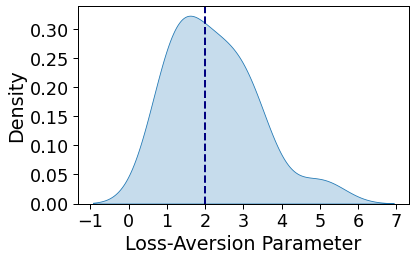

In [37]:
model_decision = Lmer("Decision ~ Gain + Loss + (Gain + Loss |Subject)", data=loss_aversion_metadata.dropna(), family='binomial')
model_decision.fit(verbose=False)


loss_aversion_parameter_behavior = -1 * (model_decision.fixef['Loss']/model_decision.fixef['Gain'])

with sns.plotting_context(context='paper', font_scale=2):
    sns.kdeplot(loss_aversion_parameter_behavior, shade='dodgerblue')
    plt.xlabel('Loss-Aversion Parameter')
#     plt.xlim([-20,55])
    plt.tight_layout()
    plt.axvline(np.median(loss_aversion_parameter_behavior), linestyle='--', color='navy', linewidth=2)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavioral_Loss_Aversion_Parameter_{analysis_name}_distribution.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Behavioral_Loss_Aversion_Parameter_{analysis_name}_distribution.pdf'))

    
print(f'\nMedian Loss Aversion: {np.median(loss_aversion_parameter_behavior):.03}\nMean Loss Aversion: {np.mean(loss_aversion_parameter_behavior):.03} \nSD Loss Aversion: {np.std(loss_aversion_parameter_behavior):.03}\n')

model_decision.summary()

## Estimate Neural Loss Aversion

boundary (singular) fit: see help('isSingular') 

Formula: Similarity_z~Gain+Loss+(Gain+Loss|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2736	 Groups: {'Subject': 16.0}

Log-likelihood: -3877.513 	 AIC: 7755.026

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.013
Subject          Gain  0.000  0.000
Subject          Loss  0.000  0.001
Residual               0.988  0.994

                 IV1   IV2   Corr
Subject  (Intercept)  Gain -1.000
Subject  (Intercept)  Loss -0.998
Subject         Gain  Loss  0.998

Fixed effects:


Median Loss Aversion: 6.72
Mean Loss Aversion: 6.72 
SD Loss Aversion: 0.035

Formula: Similarity_z~Gain+Loss+(Gain+Loss|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2736	 Groups: {'Subject': 16.0}

Log-likelihood: -3877.513 	 AIC: 7755.026

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.000  0.013
Subject          Gain  0.000  0.000
Subject

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.149,0.002,0.297,0.075,61.475,1.988,0.051,.
Gain,0.003,-0.002,0.007,0.002,441.571,1.232,0.219,
Loss,-0.017,-0.025,-0.009,0.004,98.519,-4.206,0.000,***


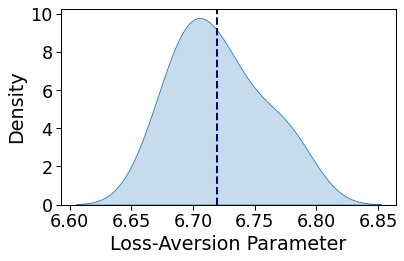

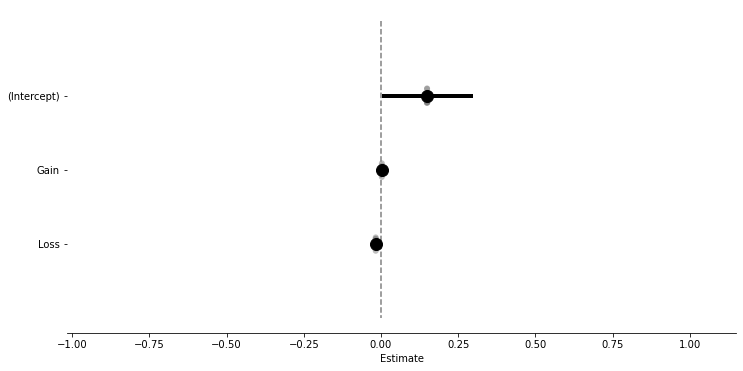

In [78]:
calc_zscore = lambda x: (x - x.mean()) / x.std()

loss_aversion_metadata['Similarity_z'] = loss_aversion_metadata['Similarity'].groupby(loss_aversion_metadata['Subject']).transform(calc_zscore)

model_brain = Lmer("Similarity_z ~ Gain + Loss + (Gain + Loss|Subject)", data=loss_aversion_metadata)

model_brain.fit(verbose=False)

loss_aversion_parameter_brain = -1*model_brain.fixef['Loss']/(model_brain.fixef['Gain'])

with sns.plotting_context(context='paper', font_scale=2):
    sns.kdeplot(loss_aversion_parameter_brain, shade='dodgerblue')
    plt.xlabel('Loss-Aversion Parameter')
#     plt.xlim([-20,55])
    plt.tight_layout()
    plt.axvline(np.median(loss_aversion_parameter_brain), linestyle='--', color='navy', linewidth=2)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Neural_Loss_Aversion_Parameter_{analysis_name}_distribution.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Neural_Loss_Aversion_Parameter_{analysis_name}_distribution.pdf'))

print(f'\nMedian Loss Aversion: {np.median(loss_aversion_parameter_brain):.03}\nMean Loss Aversion: {np.mean(loss_aversion_parameter_brain):.03} \nSD Loss Aversion: {np.std(loss_aversion_parameter_brain):.03}\n')

model_brain.plot_summary()

model_brain.summary()

## Prediction Behavioral Loss Aversion from Neural Loss Aversion

In [86]:
model_brain = Lmer("Similarity ~ Gain + Loss + (Gain + Loss|Subject)", data=loss_aversion_metadata)
model_brain.fit(verbose=True)

loss_aversion_parameter_brain = -1*model_brain.fixef['Loss']/(model_brain.fixef['Gain'])
model_brain.summary()

R[write to console]: boundary (singular) fit: see help('isSingular')



Fitting linear model using lmer with Wald confidence intervals...

boundary (singular) fit: see help('isSingular') 

Formula: Similarity~Gain+Loss+(Gain+Loss|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2736	 Groups: {'Subject': 16.0}

Log-likelihood: 6563.198 	 AIC: -13126.397

Random effects:

                 Name  Var    Std
Subject   (Intercept)  0.0  0.000
Subject          Gain  0.0  0.000
Subject          Loss  0.0  0.000
Residual               0.0  0.022

                 IV1   IV2      Corr
Subject  (Intercept)  Gain          
Subject  (Intercept)  Loss          
Subject         Gain  Loss  0.998598

Fixed effects:

Formula: Similarity~Gain+Loss+(Gain+Loss|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2736	 Groups: {'Subject': 16.0}

Log-likelihood: 6563.198 	 AIC: -13126.397

Random effects:

                 Name  Var    Std
Subject   (Intercept)  0.0  0.000
Subject          Gain  0.0  0.000
Subject          Loss  0.

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-0.001,-0.004,0.002,0.002,2717.581,-0.557,0.578,
Gain,0.000,-0.000,0.000,0.000,98.873,1.128,0.262,
Loss,-0.000,-0.001,-0.000,0.000,42.864,-3.840,0.000,***


In [80]:
n_permute = 10000
permuted_r = []
for i in range(n_permute):
    permuted_r.append(spearmanr(np.random.permutation(loss_aversion_parameter_brain), loss_aversion_parameter_behavior)[0])
r = spearmanr(loss_aversion_parameter_brain, loss_aversion_parameter_behavior)[0]
p = _calc_pvalue(permuted_r, r, 1)
print(r, p)



0.4794117647058824 0.0313968603139686


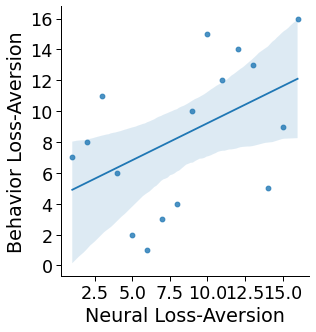

In [84]:
loss_aversion = pd.DataFrame({'Behavior':loss_aversion_parameter_behavior,
                              'Brain':loss_aversion_parameter_brain})

with sns.plotting_context(context='paper', font_scale=2):
    sns.lmplot(data=loss_aversion.rank(), y='Behavior', x='Brain')
    plt.ylabel('Behavior Loss-Aversion')
    plt.xlabel('Neural Loss-Aversion')
#     plt.xlim([1,16])
    plt.tight_layout()
#     plt.axvline(np.median(loss_aversion_parameter_behavior), linestyle='--', color='navy', linewidth=2)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Loss_Aversion_Brain_Behavior_Correlation_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', 'Neural_Loss_Aversion', f'Loss_Aversion_Brain_Behavior_Correlation_{analysis_name}.pdf'))



# Test Friday Night Lights - Naturalistic Data

## Compute pattern similarity (Only need to run once)

In [95]:
# fnl_fmri_dir = '/Storage/Data/FridayNightLights_Study2/derivatives/denoised/smoothed'
fnl_fmri_dir = '/Storage/Data/FridayNightLights_Study2/derivatives/denoised_original'
fnl_data_dir = '/Storage/Projects/vmpfc/Data'

similarity_method = 'correlation'

# Get Reward Model Predictions
for analysis_name in ['demeaned_zscore1_smooth0', 'masked_demeaned_zscore1_smooth0']:
    reward_model = Brain_Data(os.path.join(data_dir, 'Analyses', 'Classification', f'SVM_HCP_Reward_vs_Punish_n392_{analysis_name}_weightmap.nii.gz'))
    file_list = glob.glob(os.path.join(fnl_fmri_dir, '*hdf5'))

    fnl_similarity = {}
    for f in tqdm(file_list):
        sub = os.path.basename(f).split('_')[0]
        dat = Brain_Data(f)
        fnl_similarity[sub] = dat.similarity(reward_model, method=similarity_method)
    fnl_similarity = pd.DataFrame(fnl_similarity)
    fnl_similarity.to_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity', f'FNL_Reward_Pattern_Similarity_{analysis_name}_{similarity_method}.csv'), index=False)


100%|███████████████████████████████████| 35/35 [01:17<00:00,  2.21s/it]


## Compute ISC for Reward Model During Final Football Scene

In [133]:
fnl_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity', f'FNL_Reward_Pattern_Similarity_{analysis_name}_{similarity_method}.csv'))
fnl_similarity['TR'] = fnl_similarity.index
reward =  fnl_similarity.iloc[1175:1275, :]
reward.drop(columns='TR')

isc_stats = isc(reward.drop(columns='TR'), metric='mean')
isc_stats

{'isc': 0.31076109947151537,
 'p': 0.0001999600079984003,
 'ci': (0.28614748831120507, 0.35815795770206865)}

## Compute ISC for Reward Model Over Entire Episode

In [132]:
fnl_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity', f'FNL_Reward_Pattern_Similarity_{analysis_name}_{similarity_method}.csv'))

isc_stats = isc(fnl_similarity, metric='mean')
isc_stats

{'isc': 0.3514517700197037,
 'p': 0.0001999600079984003,
 'ci': (0.32272764524555975, 0.40178262547411575)}

## Compute ISC in Visual Cortex

In [104]:
from nltools.stats import isc

roi = 4
mask = Brain_Data(os.path.join(data_dir, 'Masks','k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

file_list = glob.glob(os.path.join('/Storage/Data/FridayNightLights_Study2/derivatives/denoised/smoothed', '*hdf5'))
out = []
for f in tqdm(file_list):
    sub = os.path.basename(f).split('_')[0]
    sub_data = Brain_Data(f)
    out.append({'sub':sub, 'V1':sub_data.apply_mask(mask_x[roi]).mean(axis=1)})

out = pd.DataFrame(out)

v1 = pd.DataFrame([x for x in out['V1']]).T
isc_stats = isc(v1, metric='mean')
isc_stats

100%|███████████████████████████████████| 35/35 [00:38<00:00,  1.11s/it]


{'isc': 0.333462179161094,
 'p': 0.0001999600079984003,
 'ci': (0.2792247680597074, 0.3973745973430084)}

## Create Face Model based on Reward Model Predictions

### Prepare AU Data (only need to run once)

In [ ]:
# Create average AU by Time
file_list = glob.glob(os.path.join(fnl_data_dir, 'Study3_FaceExpressions','*_FaceExpression_AU_0.5hz.csv'))
sub_out = []
for f in file_list:
    sub = os.path.basename(f).split('_')[0]
    tmp = center(pd.read_csv(f,index_col=0))
    au_list = tmp.columns
    tmp['Subject']  = sub
    sub_out.append(tmp)
sub_out = pd.concat(sub_out)
sub_out.reset_index(inplace=True, drop=True)
au_mean = {}
for au in list(sub_out.columns[:-1]):
    au_subs = {}
    for sub in sub_out['Subject'].unique():
        au_subs[sub] = sub_out.query('Subject==@sub')[au].values
    au_mean[au] = pd.DataFrame(au_subs).mean(axis=1)
au_mean = zscore(pd.DataFrame(au_mean))
au_mean.to_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity','FNL_AU_Mean.csv'), index=False)


### Estimate Cross-Validated Face Expression Model

In [100]:
similarity_method = 'correlation'

au_mean = zscore(pd.read_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity', 'FNL_AU_Mean.csv')))

fnl_similarity = pd.read_csv(os.path.join(data_dir, 'Analyses', 'FNL_Pattern_Similarity', f'FNL_Reward_Pattern_Similarity_{analysis_name}_{similarity_method}.csv'))
fnl_similarity['TR'] = fnl_similarity.index
fnl_similarity = fnl_similarity.iloc[:au_mean.shape[0]]
au_mean = au_mean.iloc[1175:1275, :]
reward =  fnl_similarity.iloc[1175:1275, :]
combined = pd.concat([reward, au_mean], axis=1)
combined_long = combined.melt(id_vars=list(au_mean.columns)+['TR'], var_name='Subject', value_name='Reward')

# LOSO Cross-Validate
group_kfold = GroupKFold(n_splits=5)
X = combined_long.loc[:,['AU1','AU2','AU4','AU5','AU6','AU7','AU9','AU10','AU12','AU14','AU15','AU17','AU18','AU20','AU23','AU24','AU25','AU26','AU28','AU43']].values
y = combined_long['Reward'].values
grouping = combined_long['Subject'].values

combined_long['Face_Prediction'] = np.nan
for train_index, test_index in group_kfold.split(X, y, grouping):
    au_regress = Lm("Reward ~ AU1 + AU2 + AU4 + AU5 + AU6 + AU7 + AU9 + AU10 + AU12 + AU14 + AU15 + AU17 + AU18 + AU20 + AU23 + AU24 + AU25 + AU26 + AU28 + AU43", data=combined_long.iloc[train_index,:])
    au_regress.fit(verbose=False)
    combined_long['Face_Prediction'].iloc[test_index] = au_regress.predict(combined_long.iloc[test_index,:])


Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2800	 R^2: 0.175	 R^2_adj: 0.169

Log-likelihood: 5122.938 	 AIC: -10203.876	 BIC: -10079.191

Fixed effects:

Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2800	 R^2: 0.191	 R^2_adj: 0.185

Log-likelihood: 5091.415 	 AIC: -10140.831	 BIC: -10016.146

Fixed effects:

Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2800	 R^2: 0.189	 R^2_adj: 0.183

Log-likelihood: 5182.873 	 AIC: -10323.745	 B

/tmp/ipykernel_783552/1680626347.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_long['Face_Prediction'].iloc[test_index] = au_regress.predict(combined_long.iloc[test_index,:])
/tmp/ipykernel_783552/1680626347.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_long['Face_Prediction'].iloc[test_index] = au_regress.predict(combined_long.iloc[test_index,:])
/tmp/ipykernel_783552/1680626347.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

### Cross-Validated Predictions

Mean: 0.39, SD: 0.12


{'mean': 0.3947270155586987, 'p': 0.0001999600079984003}

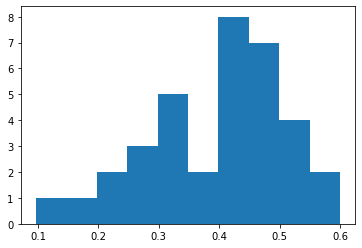

In [101]:
sub_list = combined_long['Subject'].unique()

xval_r = []
for sub in sub_list:
    xval_r.append(spearmanr(combined_long.query('Subject==@sub')['Reward'], combined_long.query('Subject==@sub')['Face_Prediction'])[0])
plt.hist(xval_r)
print(f'Mean: {np.mean(xval_r):.02}, SD: {np.std(xval_r):.02}')

one_sample_permutation(xval_r)

### Plot Average Estimated Face Model

Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 100	 R^2: 0.331	 R^2_adj: 0.162

Log-likelihood: 197.036 	 AIC: -352.073	 BIC: -297.364

Fixed effects:

Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 100	 R^2: 0.352	 R^2_adj: 0.188

Log-likelihood: 179.452 	 AIC: -316.904	 BIC: -262.195

Fixed effects:

Formula: Reward~AU1+AU2+AU4+AU5+AU6+AU7+AU9+AU10+AU12+AU14+AU15+AU17+AU18+AU20+AU23+AU24+AU25+AU26+AU28+AU43

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 100	 R^2: 0.393	 R^2_adj: 0.239

Log-likelihood: 211.828 	 AIC: -381.656	 BIC: -326.948

Fi

<AxesSubplot:>

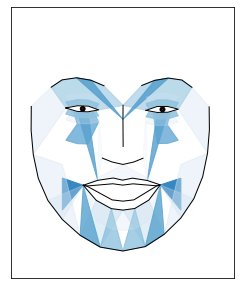

In [121]:
# Estimate AU weights for each imaging subjet
all_wts = {}
for s in combined_long['Subject'].unique():
    au_regress = Lm("Reward ~ AU1 + AU2 + AU4 + AU5 + AU6 + AU7 + AU9 + AU10 + AU12 + AU14 + AU15 + AU17 + AU18 + AU20 + AU23 + AU24 + AU25 + AU26 + AU28 + AU43", data=combined_long.query('Subject==@s'))
    au_regress.fit(verbose=False)
    au_wts = au_regress.coefs['Estimate']
    all_wts[s] = au_wts
all_wts = pd.DataFrame(all_wts).T

aus = pd.Series(minmax_scale(all_wts.drop(columns=['Intercept']).mean(), feature_range=(0,1)), index=au_wts.drop('Intercept').index)



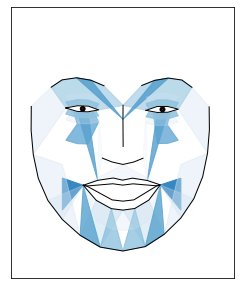

In [123]:
# Plot Average
muscles = {'all': 'heatmap'}
plot_face(au=aus.values, muscles=muscles)
plt.savefig(os.path.join(data_dir, 'Figures', f'Face_Expression_FNL_Reward_Similarity_Final_Football_{analysis_name}.png'), dpi=300)
plt.savefig(os.path.join(data_dir, 'Figures', f'Face_Expression_FNL_Reward_Similarity_Final_Football_{analysis_name}.pdf'))



### Create Time Series Plot

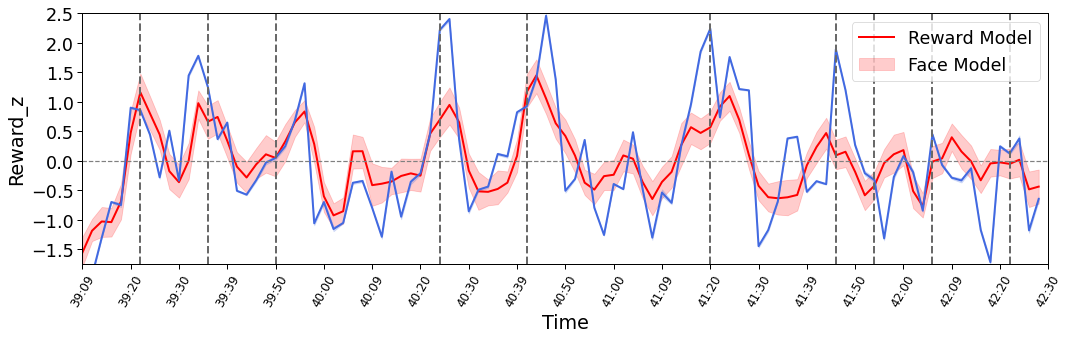

In [102]:

successful_plays = {
                    'Saracen goes back on field after pep talk from Coach Taylor':'39:23',
                    'Transition from graphic spinal surgery back to game':'39:37',
                   'Saracen successful pass':'39:50',
                   'Smash scores touchdown':'40:24',
                   'Successful onside punt':'40:43',
                   'Smash runs out of bounds to stop clock':'41:20',
                    'Saracen succesfully recovers from almost falling':'41:47',
                    'Saracen succesfully evades being sacked':'41:55',
                    'Saracen succesfully gets pass off':'42:06',
                    'Smash scores winning touchdown':'42:22'
                   }

football_plays = {'Touchdown Dillon':'30:16', 
                    'Touchdown Westerby':'30:33', 
                    'Westerby Blocks Pass':'32:09', 
                    'Street Taken off Field':'35:39',
                    'Saracen Goes Back on Field After Pep Talk from Coach Taylor':'39:28',
                   'Saracen Successful Pass':'39:50',
                   'Smash Scores Touchdown':'40:24',
                   'Successful Onside Punt':'40:43',
                   'Smash Runs Out of Bounds to Stop Clock':'41:20',
                    'Saracen Succesfully Recovers from Almost Falling':'41:47',
                    'Saracen Succesfully Evades being sacked':'41:55',
                    'Saracen succesfully gets pass off':'42:08',
                    'Scores winning touchdown':'42:22'
                   }


calc_zscore = lambda x: (x - x.mean()) / x.std()
combined_long['Reward_z'] = combined_long['Reward'].groupby(combined_long['Subject']).transform(calc_zscore)
combined_long['Face_Prediction_z'] = combined_long['Face_Prediction'].groupby(combined_long['Subject']).transform(calc_zscore)

with sns.plotting_context(context='paper', font_scale=2):
    f,a = plt.subplots(figsize=(15,5))

    sns.lineplot(data=combined_long, x='TR', y='Reward_z', ax=a, linewidth=2, color='red')
    sns.lineplot(data=combined_long, x='TR', y='Face_Prediction_z', ax=a, linewidth=2, color='royalblue')
    plt.axhline(0, color='grey', linestyle='--')

    # plt.legend(['Reward', 'PINES', 'AU12', ])
    a.set_xticks(range(0, fnl_similarity.shape[0], 5))
    a.set_xticklabels(rec_to_time(range(0, fnl_similarity.shape[0], 5), TR=2.0), rotation=60, fontsize=12)

    for time_stamp in [time_stamp_to_tr(x) for x in list(successful_plays.values())]:
        plt.axvline(time_stamp, color='dimgrey', linestyle='--', linewidth=2)

#     a.plot(convolved_events, color='pink')
    
    a.set_xlim([1175,1275])
    a.set_ylim([-1.75, 2.5])
#     a.set_ylabel('Reward Prediction')
    a.set_xlabel('Time')
    plt.legend(['Reward Model', 'Face Model'])
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'Figures', f'FNL_Reward_Similarity_Final_Football_Face_{analysis_name}.png'), dpi=300)
    plt.savefig(os.path.join(data_dir, 'Figures', f'FNL_Reward_Similarity_Final_Football_Face_{analysis_name}.pdf'))
    